Here we seek to solve
\begin{align}
\min_{(u,\rho)\in\mathcal{V}\times\mathcal{M}}J(u,\rho)&:=\frac{1}{2}\int_{\Omega}(u-u_{d})^{2}\mathrm{d}V+\frac{1}{2}R(\rho)\\
R(\rho)&:=\int_{\Omega}(\gamma_{1}\,\rho^{2}+\gamma_{2}\nabla \rho\cdot\nabla \rho)\mathrm{d}V
\end{align}

subject to the partial differential equality constraint

\begin{align*}
-\nabla\cdot\left(\rho\,\nabla u\right)+\beta\, u&=f,\,\,\,\text{ in }\Omega \\
\frac{\partial u}{\partial n}&=0,\,\,\,\text{ on }\partial\Omega
\end{align*}

and bound constraint

\begin{align*}
\rho(x)\geq \rho_{\ell}(x)>0,\,\,\,\text{ on }\overline{\Omega}
\end{align*}

here $\beta\in\mathbb{R}$, $f:\Omega\rightarrow\mathbb{R}$, $u_{d}:\Omega\rightarrow\mathbb{R}$, $\rho_{\ell}:\overline{\Omega}\rightarrow\mathbb{R}_{>0}$, $\lbrace \gamma_{j}\rbrace_{j=1}^{2}\subset\mathbb{R}_{\geq 0}$ are given.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import dolfin as dl
# False - natural ordering; True - interlace
dl.parameters['reorder_dofs_serial'] = False


from filterLineSearchSparse import interior_pt
from hippylib import nb

from helperfunctions import *

from problems import inverseDiffusion

In [2]:
plt.style.use('classic')
plt.rcParams.update({'font.size': 16})

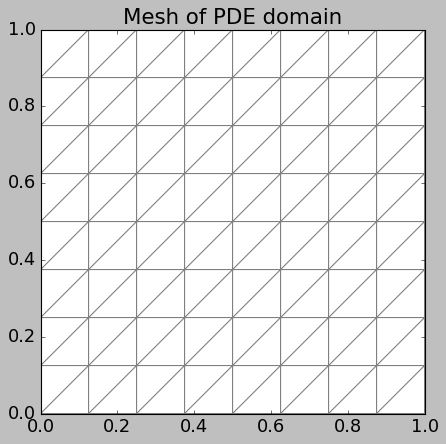

In [3]:
nx_coarse = 4 
nx = 8

# coarse and fine meshes
mesh_coarse = dl.UnitSquareMesh(nx_coarse, nx_coarse)

mesh_fine   = dl.UnitSquareMesh(nx, nx)

meshes = [mesh_coarse, mesh_fine]
mesh   = meshes[-1]
lvl    = len(meshes) # depth of mesh hierarchy
dl.plot(mesh)
plt.title('Mesh of PDE domain')
plt.show()

In [4]:
P1_deg = 1 # degree of finite-element polynomials for parameter (rho)
P2_deg = 2 # degree of finite-element polynomials for state

P1s  = [dl.FiniteElement("CG", meshes[i].ufl_cell(), P1_deg) for i in range(lvl)]
P2s  = [dl.FiniteElement("CG", meshes[i].ufl_cell(), P2_deg) for i in range(lvl)] 
Ths  = [dl.MixedElement([P2s[i], P1s[i]]) for i in range(lvl)]
Vhs  = [dl.FunctionSpace(meshes[i], Ths[i]) for i in range(lvl)]
Vh1s = [dl.FunctionSpace(meshes[i], P1s[i]) for i in range(lvl)]
Vh2s = [dl.FunctionSpace(meshes[i], P2s[i]) for i in range(lvl)]

P1  = P1s[-1]
P2  = P2s[-1]
Th  = Ths[-1]
Vh  = Vhs[-1]
Vh1 = Vh1s[-1]
Vh2 = Vh2s[-1]

print("dim(state) = {0:d}, dim(parameter) = {1:d}".format(Vh.sub(0).dim(), Vh.sub(1).dim()))

dim(state) = 289, dim(parameter) = 81


In [5]:
beta   = 1.
gamma1 = 1.e-4
gamma2 = 1.e-4
Crhol  = 0.75


rhols = [dl.interpolate(dl.Expression('C', element=Vh1s[i].ufl_element(), C=Crhol), Vh1s[i]).vector().get_local() \
         for i in range(lvl)]
uds   = [dl.interpolate(dl.Expression('std::cos(x[0]*pi)*std::cos(x[1]*pi)',\
                                          pi=np.pi, element=Vh2s[i].ufl_element()), Vh2s[i]) \
         for i in range(lvl)]
gs   =  [dl.interpolate(dl.Expression('(2.*pi*pi*(0.5+x[0]) + beta)*std::cos(x[0]*pi)*std::cos(x[1]*pi)'+\
                                          '+pi*std::sin(pi*x[0])*std::cos(pi*x[1])',\
                                           pi=np.pi, beta=beta, element=Vh2s[i].ufl_element()), Vh2s[i]) \
         for i in range(lvl)]

problems = [inverseDiffusion(Vhs[i], Vh1s[i], Vh2s[i], beta, gamma1, gamma2, uds[i], gs[i], rhols[i]) \
           for i in range(lvl)]

rhol = rhols[-1]
ud   = uds[-1]
g    = gs[-1]
problem = problems[-1]

rhotrue = dl.interpolate(dl.Expression('0.5+x[0]',\
                                      element=Vh1.ufl_element()), Vh1)

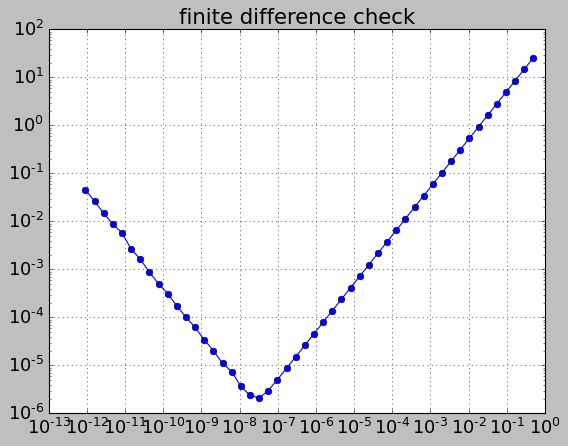

In [6]:
# ---- gradient check   
    
F     = lambda x : problem.c(x)
gradF = lambda x : problem.Dxc(x)

# initial point
x0 = np.array([1.+np.random.randn() if i < Vh2.dim() \
      else (abs(np.random.randn())+1. + rhol[i-Vh2.dim()]) for i in range(Vh.dim())])
xhat = np.random.randn(Vh.dim()) 


grad_check(F, gradF, x0, xhat)

In [7]:
solver = interior_pt(problem)
x0      = np.ones(problem.n)
x0[:problem.n1] = problem.restore_feasibility(x0)
X0      = [x0, np.ones(problem.m), np.ones(problem.n2)]
solver.initialize(X0)
mu0 = 1.e0
opttol = 1.e-6
max_it = 5
Xf, mu, E, Mus = solver.solve(opttol, max_it, mu0)
xf, lamf, zf = Xf[:]

-------------------------------------------------- it = 0
solved barrier problem (mu = 1.000e+00)
solved barrier problem (mu = 5.000e-01)
solved barrier problem (mu = 2.500e-01)
solved barrier problem (mu = 1.250e-01)
-------------------------------------------------- determining search direction 
KKT sys error = 8.978e-15
NO INERTIA CORRECTION WAS REQUIRED
alpha = 1.000e+00, alphaz = 9.531e-01
in filter region?  False
A.5.4
theta(x) = 3.85e-14
angle between xhat and Dxphi = 135.3 (degrees)
descent direction?  True
theta(x) < theta_min?  True
step accepted A-5.4 CASE I
linesearch success?  True
accepted trial point for the subproblem
-------------------------------------------------- it = 1
solved barrier problem (mu = 4.419e-02)
solved barrier problem (mu = 9.291e-03)
-------------------------------------------------- determining search direction 
KKT sys error = 5.007e-15
NO INERTIA CORRECTION WAS REQUIRED
alpha = 1.000e+00, alphaz = 9.515e-01
in filter region?  False
A.5.4
theta(x) 

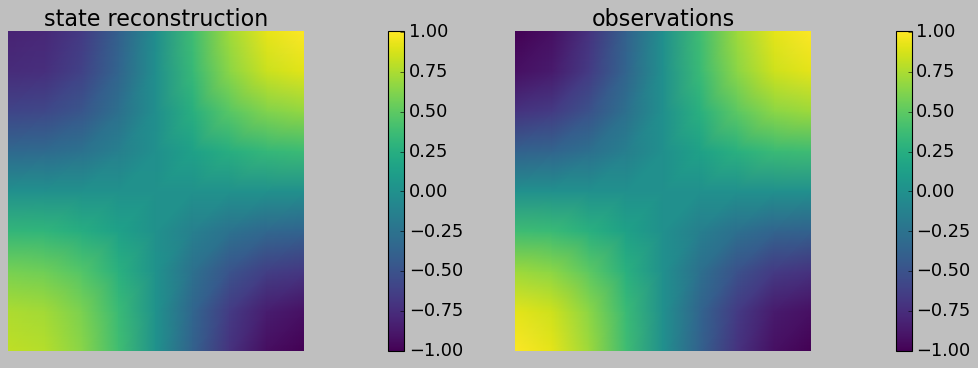

In [8]:
uReconstruction   = dl.Function(Vh2)
lamReconstruction = dl.Function(Vh2)

rhoReconstruction = dl.Function(Vh1)
zReconstruction   = dl.Function(Vh1)

uReconstruction.vector()[:]   = xf[:problem.n1]
rhoReconstruction.vector()[:] = xf[problem.n1:]

lamReconstruction.vector()[:] = lamf[:]
zReconstruction.vector()[:]   = zf[:]

nb.multi1_plot([uReconstruction, ud], ["state reconstruction", "observations"])
plt.show()

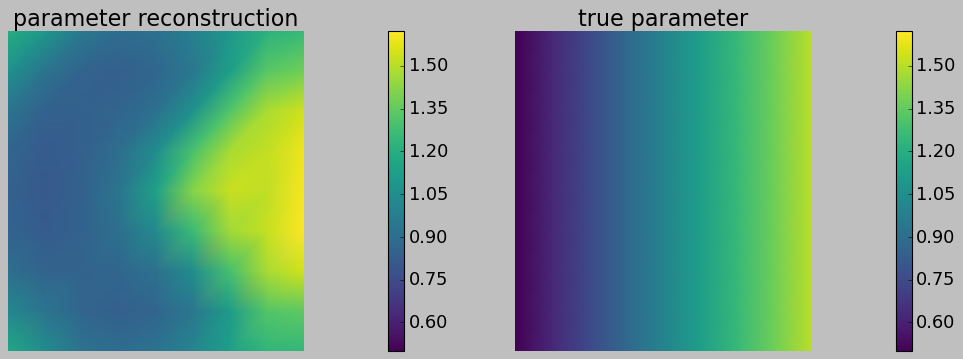

In [9]:
nb.multi1_plot([rhoReconstruction, rhotrue], ["parameter reconstruction", "true parameter"])
plt.show()

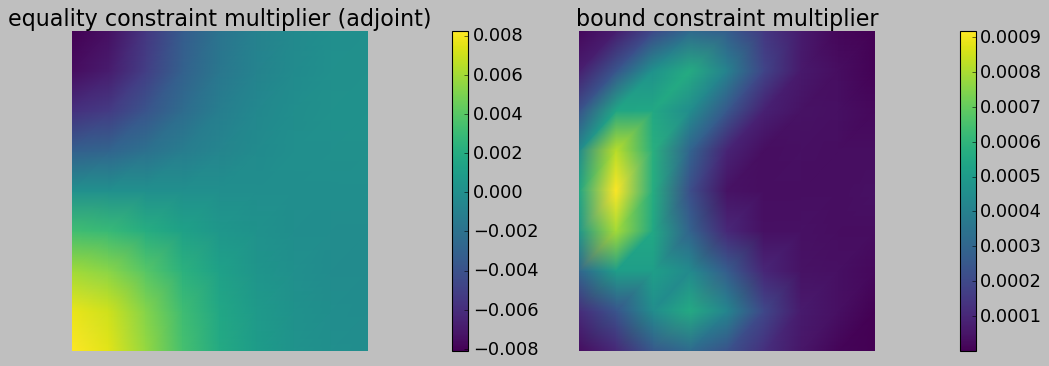

5.23e-09 <= z <= 9.19e-04
portion of bound constraint dofs below tol = 0.02


In [10]:
nb.multi1_plot([lamReconstruction, zReconstruction], \
            ["equality constraint multiplier (adjoint)", "bound constraint multiplier"],\
            same_colorbar=False)
plt.show()

print("{0:1.2e} <= z <= {1:1.2e}".format(min(zf), max(zf)))
print("portion of bound constraint dofs below tol = {0:1.2f}".format(sum(zf < opttol)/len(zf)))

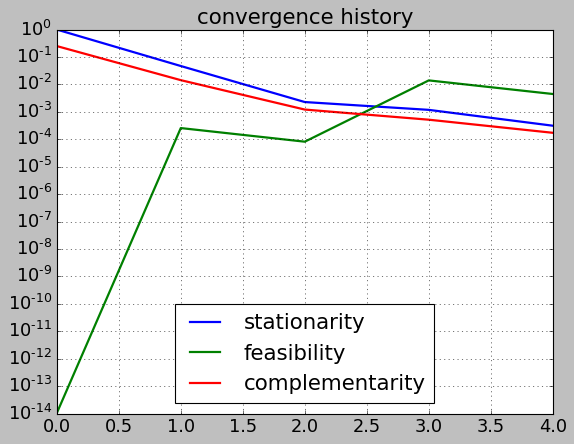

In [11]:
Es = [[E[i][j] for i in range(len(E))] for j in range(len(E[0]))]
labels = ["optimality error", "stationarity", "feasibility", "complementarity"]

for i in range(1,4):
    plt.plot(Es[i], label=labels[i], linewidth=2.0)
    plt.yscale('log')
plt.legend(loc = 'lower center')
plt.grid()
plt.title('convergence history')
plt.show()

In [12]:
hierarchy = multigridHierarchy(problems)
hierarchy.constructPreconditioner(Xf)
mu = Mus[-1]
print("mu final = {0:1.2e}".format(mu))

KKT system Schur complement max eigenvalue = 1.71e+05 converged in 115 iterations
mu final = 2.68e-05


In [13]:
rk = np.zeros(problem.n + problem.m)
Ak, Jk, drk = solver.formH(Xf, mu)
JkT = Jk.transpose()
rk[:problem.n] = problem.Dxf(Xf[0]) + JkT.dot(Xf[1])
rk[problem.n:] = problem.c(Xf[0])
rk[problem.n1:problem.n] += drk[:]

In [14]:
smoothing_steps_set = [1, 10, 100]
lintol  = 1.e-10
maxiter = 50
krylov_convergence = Krylov_convergence(Ak, -rk)

residuals_twogrids = [[] for i in smoothing_steps_set]

for i, smoothing_steps in enumerate(smoothing_steps_set):
    krylov_convergence.reset()
    # ---- GMRES-twogrid solve
    two_grid_P = two_grid_action(hierarchy.Lfine, hierarchy.Lcoarse, hierarchy.S, hierarchy.P, hierarchy.R, \
                             smoothing_steps)
    u, info = spla.gmres(Ak, -rk, tol=lintol, atol=lintol, \
                   M = two_grid_P, maxiter=maxiter, callback=krylov_convergence.callback)
    residuals_twogrid = np.array(krylov_convergence.residuals).copy()
    residuals_twogrids[i] = residuals_twogrid
    krylov_convergence.reset()
    
    # ---- GMRES-twogrid with fine grid correction
    two_grid_P = two_grid_action(hierarchy.Lfine, hierarchy.Lcoarse, hierarchy.S, hierarchy.P, hierarchy.R, \
                             smoothing_steps, coarsegridcorrection=False)
    u, info = spla.gmres(Ak, -rk, tol=lintol, atol=lintol, \
                   M = two_grid_P, maxiter=maxiter, callback=krylov_convergence.callback)
    residuals_finegrid = np.array(krylov_convergence.residuals).copy()
    if len(residuals_finegrid) < maxiter:
        print("two-grid with fine grid correction successful")
        print("final residual = {0:1.2e}".format(np.linalg.norm(Ak.dot(u)+rk)))
    
    krylov_convergence.reset()

    # ---- GMRES with no preconditioner
    u, info = spla.gmres(Ak, -rk, tol=lintol, atol=lintol, \
                   maxiter=maxiter, callback=krylov_convergence.callback)
    residuals_noP = np.array(krylov_convergence.residuals).copy()



two-grid with fine grid correction successful
final residual = 1.96e-11
two-grid with fine grid correction successful
final residual = 4.13e-12
two-grid with fine grid correction successful
final residual = 6.93e-13


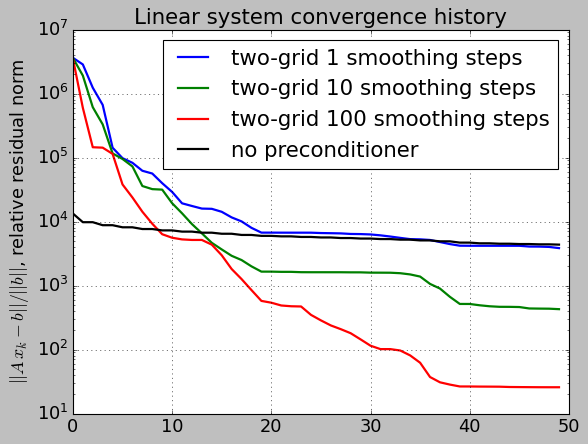

In [15]:
for i, smoothing_steps in enumerate(smoothing_steps_set):
    plt.plot(residuals_twogrids[i], label='two-grid {0:d} smoothing steps'.format(smoothing_steps), linewidth=2.0)
plt.plot(residuals_noP, 'k', label='no preconditioner', linewidth=2.0)
plt.yscale('log')
plt.ylabel(r'$||A\,x_{k}-b||/||b||$, relative residual norm')
plt.title('Linear system convergence history')
plt.legend()
plt.grid()
plt.show()

We next investigate the IP-Newton system matrix, with block structure
$$
A = \begin{pmatrix}
W & J^{\top} \\
J & 0
\end{pmatrix}
$$
where $J$ is the constraint Jacobian and $W$ is the Hessian of the Lagrangian with an interior-point perturbation.

In [16]:
condAk = np.linalg.cond(Ak.todense())
condWk = np.linalg.cond(Ak.todense()[:problem.n,:problem.n])
eigWk  = np.linalg.eigvals(Ak.todense()[:problem.n,:problem.n])

JWJT = (Jk.todense().dot(Ak.todense()[:problem.n, :problem.n]).dot(JkT.todense()))




condJJT = np.linalg.cond(Jk.dot(JkT).todense())
print("cond(A) = {0:1.2e}".format(condAk))
print("cond(W) = {0:1.2e}".format(condWk))
print("minimum eigenvalue of W = {0:1.2e}".format(min(eigWk)))
print("cond(J J^T) = {0:1.2e}".format(condJJT))

cond(A) = 2.34e+05
cond(W) = 3.65e+02
minimum eigenvalue of W = 4.20e-05
cond(J J^T) = 1.95e+07


We next investigate the quality of the two-grid preconditioner with Uzawa smoothing.
The preconditioned matrix $P\,A$, is desired/expected to be well conditioned and that it is approximately equal to an identity matrix.

In [17]:
smoothing_steps=10    
    
two_grid_P = two_grid_action(hierarchy.Lfine, hierarchy.Lcoarse, hierarchy.S, hierarchy.P, hierarchy.R, \
                             smoothing_steps)


ei = np.zeros(two_grid_P.shape[0])
PAk = np.zeros(two_grid_P.shape)
SAk = np.zeros(two_grid_P.shape)


for i in range(two_grid_P.shape[0]):
    ei[i] = 1.0
    PAk[:,i] = two_grid_P._matvec(Ak.dot(ei))
    SAk[:,i] = hierarchy.S.dot(Ak.dot(ei))
    ei[i] = 0.0
condPAk = np.linalg.cond(PAk)
condSAk = np.linalg.cond(SAk)
eigIminusSA = np.abs(1. - np.linalg.eigvals(SAk))
args = np.argsort(eigIminusSA)
eigIminusSA = eigIminusSA[args[::-1]]


A sanity check for the Uzawa smoother $S$, is that for an appropriately chosen splitting parameter $\omega>0$, the Richardson iterative scheme
\begin{align*}
x_{k+1}&=x_{k}+S\,r_{k}\\
r_{k}&=b-Ax_{k}
\end{align*}
is convergent, or equivalently that the spectral radius of $I-SA$ is less than $1$.

cond(P A) = 1.09e+11
cond(S A) = 1.80e+12
spectral radius (I - P A) = 4.6347838105e+01
spectral radius (I - S A) = 9.9999998990e-01


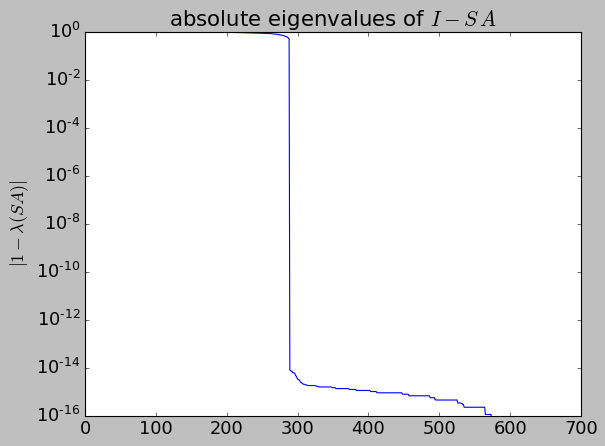

In [18]:
print("cond(P A) = {0:1.2e}".format(condPAk))
print("cond(S A) = {0:1.2e}".format(condSAk))
print("spectral radius (I - P A) = {0:1.10e}".format(max(np.abs(1.-np.linalg.eigvals(PAk)))))
print("spectral radius (I - S A) = {0:1.10e}".format(max(np.abs(1.-np.linalg.eigvals(SAk)))))

plt.plot(np.abs(eigIminusSA))
plt.yscale('log')
plt.ylabel(r'$| 1 -\lambda(SA)|$')
plt.title(r'absolute eigenvalues of $I-S\,A$')
plt.show()

To get a better sense of why $P\,A$ is so poorly conditioned, we examine it in blocks, blocks defined by the partitioning of $A$ described above.

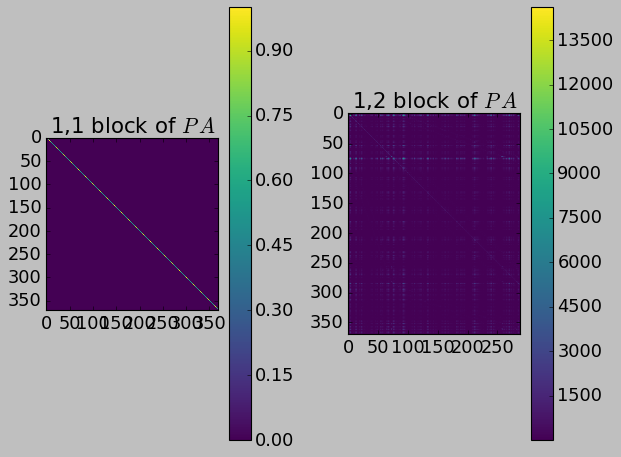

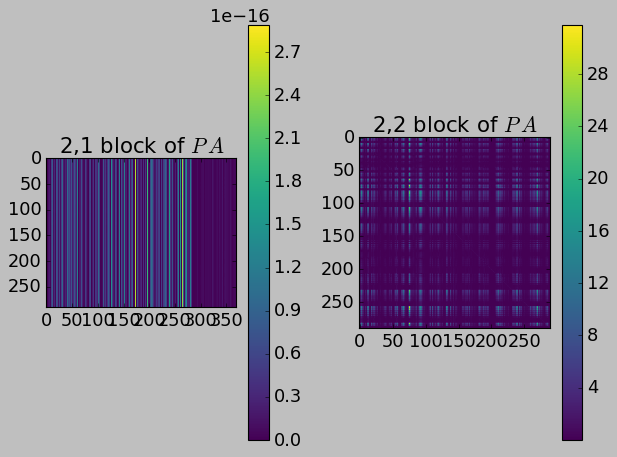

In [19]:
plt.subplot(1, 2, 1)
plt.imshow(PAk[:problem.n,:problem.n])
plt.colorbar()
plt.title(r'1,1 block of $P\,A$')
plt.subplot(1, 2, 2)
plt.imshow(np.abs(PAk[:problem.n,problem.n:]))
plt.colorbar()
plt.title(r'1,2 block of $P\,A$')
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 1)
plt.imshow(np.abs(PAk[problem.n:,:problem.n]))
plt.colorbar()
plt.title(r'2,1 block of $P\,A$')
plt.subplot(1, 2, 2)
plt.imshow(np.abs(PAk[problem.n:,problem.n:]))
plt.colorbar()
plt.title(r'2,2 block of $P\,A$')
plt.tight_layout()
plt.show()

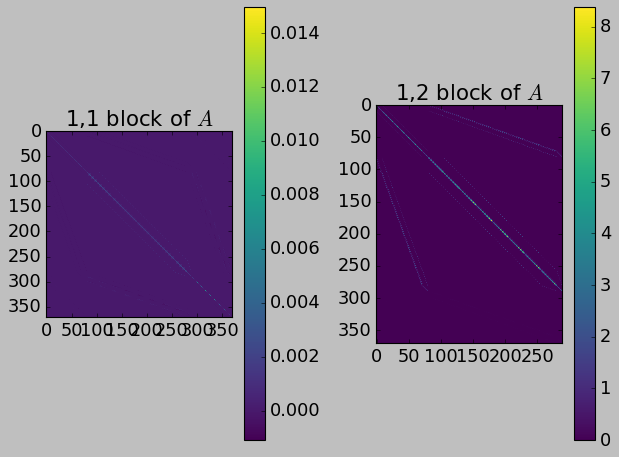

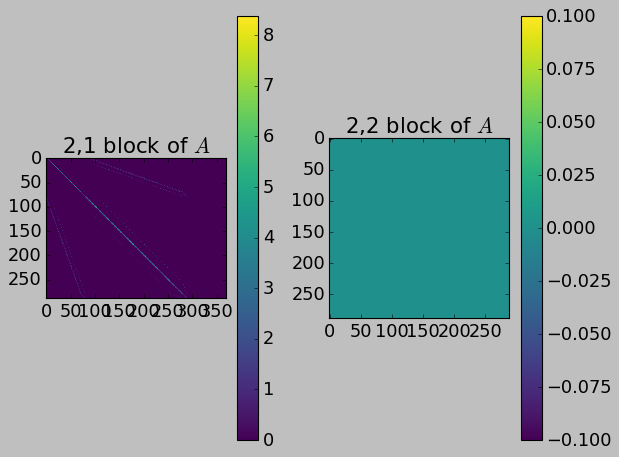

In [20]:
plt.subplot(1, 2, 1)
plt.imshow(Ak.todense()[:problem.n,:problem.n])
plt.colorbar()
plt.title(r'1,1 block of $A$')
plt.subplot(1, 2, 2)
plt.imshow(np.abs(Ak.todense()[:problem.n,problem.n:]))
plt.colorbar()
plt.title(r'1,2 block of $A$')
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 1)
plt.imshow(np.abs(Ak.todense()[problem.n:,:problem.n]))
plt.colorbar()
plt.title(r'2,1 block of $A$')
plt.subplot(1, 2, 2)
plt.imshow(np.abs(Ak.todense()[problem.n:,problem.n:]))
plt.colorbar()
plt.title(r'2,2 block of $A$')
plt.tight_layout()
plt.show()

How much of the above is due to the perturbation $z/(\rho-\rho_{\ell})$ to the Hessian of the Lagrangian?

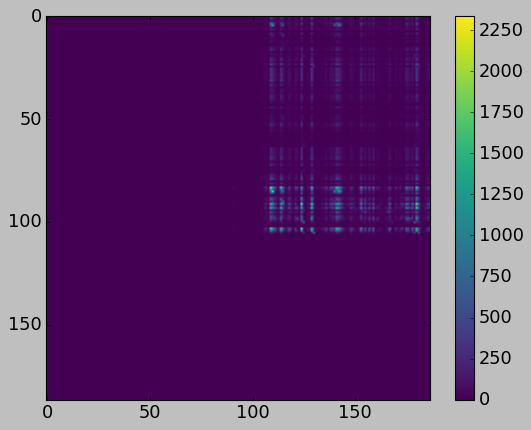

cond(Acoarse) = 1.412e+06
cond(Acoarse^-1 R Afine P) = 3.24e+08


In [21]:
LcinvLfine = spla.spsolve(hierarchy.Lcoarse.tocsc(), hierarchy.R.dot(hierarchy.Lfine).dot(hierarchy.P).tocsc())
plt.imshow(np.abs(LcinvLfine.todense()))
plt.colorbar()
plt.show()

print('cond(Acoarse) = {0:1.3e}'.format(np.linalg.cond(hierarchy.Lcoarse.todense())))
print('cond(Acoarse^-1 R Afine P) = {0:1.2e}'.format(np.linalg.cond(LcinvLfine.todense())))

KKT system Schur complement max eigenvalue = 1.71e+05 converged in 114 iterations


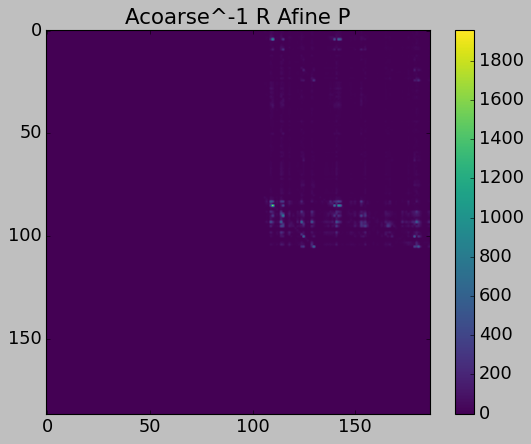

cond(Acoarse) = 2.201e+05
cond(Acoarse^-1 R Afine P) = 5.86e+08


In [22]:
hierarchy.constructPreconditioner(Xf, IPsys=False)
LcinvLfine = spla.spsolve(hierarchy.Lcoarse.tocsc(), hierarchy.R.dot(hierarchy.Lfine).dot(hierarchy.P).tocsc())


plt.imshow(np.abs(LcinvLfine.todense()))
plt.colorbar()
plt.title('Acoarse^-1 R Afine P')
plt.show()

print('cond(Acoarse) = {0:1.3e}'.format(np.linalg.cond(hierarchy.Lcoarse.todense())))
print('cond(Acoarse^-1 R Afine P) = {0:1.2e}'.format(np.linalg.cond(LcinvLfine.todense())))